# Assessment 2 - Part 1: Machine Learning
<br>

## Task: train regression models that predict two indicators of energy efficiency based on 8 numerical inputs. 
<br>

### Packages needed:

- pandas
- sklearn
- numpy
- matplotlib

### 1.1 - Data Preparation

#### Importing libraries

In [ ]:
## Imports
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Used for normalising the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## Used for regression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

## Used for assessment of regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Used for cross validation
from sklearn.model_selection import cross_val_score

#### Loading the dataset

In [ ]:
energy_data = pd.read_excel("ENB2012_data.xlsx")

energy_data.head()

#### Extracting and splitting data

In [ ]:
#inputs
inputs = energy_data.values[:,:8].astype(float)

# Projecting data into 2 dimensions with PCA.
pca = PCA(n_components = 2)
compressed_inputs = pca.fit_transform(inputs)

#normalise the inputs
scaler = MinMaxScaler()
scaled_inputs = scaler.fit_transform(inputs)

#targets
targets =  energy_data.values[:,8:].astype(float)

# Print the range of the variables to show the normalisation effect.
print(inputs.ptp(axis=0))
print(scaled_inputs.ptp(axis=0))

#### Setting up train and test data

In [ ]:
#set up data
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size=0.3, random_state=0)

### Task 1.2 - Regression

#### Regression using the "sklearn.neural_network.MLPRegressor"

In [ ]:
MLP = MLPRegressor(max_iter=10000) # <- may take a while
MLP.fit(x_train, y_train)

y_pred = MLP.predict(x_test)

##MLP test CV scores
MLP_test = abs(cross_val_score(MLP, x_test, y_test, cv=10, scoring='neg_mean_squared_error'))
print(f"Neural Network Regressor Test Cross Validation Scores: {MLP_test}")

MLP_train = abs(cross_val_score(MLP, x_train, y_train, cv=10, scoring='neg_mean_squared_error'))
print(f"Neural Network Regressor Training Cross Validation Scores: {MLP_train}")

#### Regression using the "sklearn.ensemble.RandomForestRegressor"

In [ ]:
Forest = RandomForestRegressor()

Forest.fit(x_train, y_train)

y_pred = MLP.predict(x_test)

Forest_test = abs(cross_val_score(Forest, x_test, y_test, cv=10, scoring='neg_mean_squared_error'))
print(f"Random Forest Regressor Test Cross Validation Scores: {Forest_test}")
Forest_train = abs(cross_val_score(Forest, x_train, y_train, cv=10, scoring='neg_mean_squared_error'))
print(f"Random Forest Regressor Training Cross Validation Scores: {Forest_train}")


#### Regression using the "sklearn.svm.SVR"

In [ ]:
SVR_Regressor = SVR()

SVR_Regressor.fit(x_train, y_train[:, 0])
y_pred_1 = SVR_Regressor.predict(x_test)

SVR_Regressor.fit(x_train, y_train[:, 1])
y_pred_2 = SVR_Regressor.predict(x_test)

SVR_test_1 = abs(cross_val_score(SVR_Regressor, x_test, y_test[:, 0], cv=10, scoring='neg_mean_squared_error'))
SVR_test_2 = abs(cross_val_score(SVR_Regressor, x_test, y_test[:, 1], cv=10, scoring='neg_mean_squared_error'))
print(f"1st SVR Regressor Test Cross Validation Scores: {SVR_test_1}")
print(f"2nd SVR Regressor Test Cross Validation Scores: {SVR_test_2}")

SVR_train_1 = abs(cross_val_score(SVR_Regressor, x_train, y_train[:, 0], cv=10, scoring='neg_mean_squared_error'))
SVR_train_2 = abs(cross_val_score(SVR_Regressor, x_train, y_train[:, 1], cv=10, scoring='neg_mean_squared_error'))
print(f"1st SVR Regressor Training Cross Validation Scores: {SVR_train_1}")
print(f"2nd SVR Regressor Training Cross Validation Scores: {SVR_train_2}")

### Task 1.3 - Assessment of  Regression

#### Boxplot

In [ ]:
Forest_DATA = [Forest_test, Forest_train]
MLP_DATA = [MLP_test, MLP_train]
SVR_DATA = [SVR_test_1, SVR_test_2, SVR_train_1, SVR_train_2]

## Neural Network Model

plt.figure()
plt.title("Cross Validation - Neural Networks")

# Creating plot
plt.boxplot(MLP_DATA)

plt.xticks([1, 2], ['Test Data', 'Train Data'])
plt.ylabel('MSE Rate')

# show plot
plt.show()

## Forest Model

plt.figure()
plt.title("Cross Validation - Random Forest")

# Creating plot
plt.boxplot(Forest_DATA)

plt.xticks([1, 2], ['Test Data', 'Train Data'])
plt.ylabel('MSE Rate')

# show plot
plt.show()

## SVR Model

plt.figure()
plt.title("Cross Validation - SVR")

# Creating plot
plt.boxplot(SVR_DATA)

plt.xticks([1, 2, 3, 4], ['1st Test Data', '2nd Test Data', '1st Train Data', '2nd Train Data'])
plt.ylabel('MSE Rate')

# show plot
plt.show()

# Assessment: Part 2 - Optimisation
<br>

## Task: Optimise a timetable so that session is scheduled once per week in such a way that timetable constraints are minimised. 
<br>

### Relevant constraints for this assessment are: 

- A session cannot be scheduled for a time when any of its students or staff are in another session (concurrence constraints). The sessions for a module that clash are shown in the data file.
- A lab session cannot occur in the week before its corresponding lecture has taken place (precedence constraints).
<br>
<br>

### Packages needed:

- pandas
- numpy
- matplotlib

### 2.1 – Generation of random solutions

#### Importing libraries

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt

#### Reading the file and splitting it

In [15]:
filepath = "./Modules.txt"

#Read file
file = open(filepath, 'r')
contents = file.read()
file.close()

#split it on each line
fileContents = contents.split("\n")

#different arrays
module_clashes = []
modules = []
labs = []
amount_labs = []

#put respective elements into array
for i in range(len(fileContents)):
    module_clashes.append(fileContents[i].split("|"))
    modules.append(module_clashes[i].pop(0))
    module_clashes[i].pop(0)
    labs.append(module_clashes[i].pop(0))

#split the module clashes into individual elements
for x in range(len(module_clashes)):
    module_clashes[x].append(module_clashes[x][0].split(","))
    module_clashes[x].pop(0)

# put the number of labs into an int list
for i in range(len(labs)):
    amount_labs.append(int(labs[i][0]))


print(f"Modules List: {modules}")
print(f"Number of Labs per Module List: {amount_labs}")
for i in range(len(modules)):
    print(f"Modules Clashes with: {modules[i]} clashes with {module_clashes[i]} ")

Modules List: ['MOD001', 'MOD002', 'MOD003', 'MOD004', 'MOD005', 'MOD006', 'MOD007', 'MOD008', 'MOD009', 'MOD010', 'MOD011', 'MOD012', 'MOD013', 'MOD014', 'MOD015', 'MOD016', 'MOD017']
Number of Labs per Module List: [2, 2, 2, 1, 2, 3, 1, 2, 3, 2, 2, 2, 1, 2, 2, 1, 1]
Modules Clashes with: MOD001 clashes with [['MOD002', 'MOD003', 'MOD004', 'MOD005', 'MOD006', 'MOD007', 'MOD008', 'MOD009', 'MOD010', 'MOD013']] 
Modules Clashes with: MOD002 clashes with [['MOD001', 'MOD003', 'MOD004', 'MOD005', 'MOD006', 'MOD007', 'MOD008', 'MOD009', 'MOD010', 'MOD013']] 
Modules Clashes with: MOD003 clashes with [['MOD001', 'MOD002', 'MOD004', 'MOD005', 'MOD006', 'MOD007', 'MOD008', 'MOD009', 'MOD010', 'MOD011', 'MOD012', 'MOD013']] 
Modules Clashes with: MOD004 clashes with [['MOD001', 'MOD002', 'MOD003', 'MOD005', 'MOD006', 'MOD007', 'MOD008', 'MOD009', 'MOD010', 'MOD011', 'MOD012', 'MOD013']] 
Modules Clashes with: MOD005 clashes with [['MOD001', 'MOD002', 'MOD003', 'MOD004', 'MOD006', 'MOD007', 'MO

#### Concurrent Constraints - A session cannot be scheduled for a time when any of its students or staff are in another session

#### Precedence Constraints - A lab session cannot occur in the week before its corresponding lecture has taken place

In [16]:
def concurrent_clashes(lab, module):

    concurrent_constraints = 0
    precedence_constraints = 0

    #take shortest length
    if len(lab) < len(module):
        count = len(lab)
    else:
        count = len(module)

    # check here for both constraints. First for loop looks for if two sessions have the same time period
    # second for loop looks for if the lab session occurs before the lecture of that module
    for i in range(count):
        if module[i] == lab[i]:
            concurrent_constraints = concurrent_constraints + 1
        for j in range(i):
            if j < i:
                if module[j] == lab[j]:
                    precedence_constraints = precedence_constraints + 1
                    break

    return concurrent_constraints, precedence_constraints

#### Concurrent Constraints - A session cannot be scheduled for a time when any of its students or staff are in another session

In [17]:
def modules_clashes(lab, clash, module):

    concurrent_constraints = 0
    module_element = np.array_split(modules, 17)
    
    for i in range(len(module_element)):
        for j in range(len(clash[i])):
            module_element[i] = np.concatenate([module_element[i], clash[i][j]])

    #take shortest length
    if len(lab) < len(module):
        count = len(lab)
    else:
        count = len(module)

    #find matching module
    for i in range(count):
        for j in range(len(module_element)):
            if module[i] == module_element[j][0]:
                if lab[i] is not None and lab[i] in module_element[j] and lab[i] != module_element[j][0]:
                    concurrent_constraints = concurrent_constraints + 1
                    break

    return concurrent_constraints

#### Total Constraints

In [18]:
def total_constraints(timetable, clash):

    # we generate our int lists of constraints here 
    # concurrent has 4 because there is 2 rows of labs for each function to calculate the amount of concurrent constraints
    # whereas precedence constraints happen less often than concurrent constraints
    concurrent_constraints = [int] * 4
    precedence_constraints = [int] * 2
    total_concurrent_constraints = 0
    total_precedence_constraints = 0

    # calculating the number of constraints for each module and lab
    concurrent_constraints[0], precedence_constraints[0] = concurrent_clashes(timetable[1], timetable[0])
    concurrent_constraints[1], precedence_constraints[1] = concurrent_clashes(timetable[2], timetable[0])
    concurrent_constraints[2] = modules_clashes(timetable[1], clash, timetable[0])
    concurrent_constraints[3] = modules_clashes(timetable[2], clash, timetable[0])

    #totalling constraints
    for x in range(len(concurrent_constraints)):
        total_concurrent_constraints = total_concurrent_constraints + concurrent_constraints[x]
    for y in range(len(precedence_constraints)):
        total_precedence_constraints = total_precedence_constraints + precedence_constraints[y]

    return total_concurrent_constraints, total_precedence_constraints

#### Calculating fitness

In [19]:
def return_fitness(timetable): 

    total_concurrent_constraints, total_precedence_constraints = total_constraints(timetable, module_clashes)
    #add 1 to stop fitness being 0 if one is zero to false advertise that a solution is the best solution
    fitness = (total_concurrent_constraints + 1) * (total_precedence_constraints + 1)

    return(fitness)

#### Generating random timetable

In [20]:
def generate_timetable():
    
    #lists
    lectures = []
    lab_1 = []
    lab_2 = []
    lab_sessions = []

    #generating X of lab sessions per module
    for i in range(len(modules)):
        for j in range(len(labs[i])):
            lab_sessions.append(modules[i])

    #add each module into a lecture array 
    for i in range(len(modules)):
        lectures.append(modules[i])

    # as we have 40 lab slots in our timetable and we have 31 lab sessions it will put in the amount of labs per module that we generated above
    for i in range(len(lab_sessions)):
        if i <= 20:
            lab_1.append(lab_sessions[i])
        if i > 20 and i < len(lab_sessions):
            lab_2.append(lab_sessions[i])

    #array for timetable
    timetable = np.empty([20, 3], dtype=object)
    
    #fill each column
    for i in range(len(lectures)):
        timetable[i][0] = lectures[i]
    for i in range(len(lab_1)):
        timetable[i][1] = lab_1[i]
    for i in range(len(lab_2)):
        timetable[i][2] = lab_2[i]

    # Shuffle the lectures and labs so the solution is random.
    random.shuffle(timetable[0])
    random.shuffle(timetable[1])
    random.shuffle(timetable[2])
    
    #get fitness of current timetable
    fitness = return_fitness(timetable)
    
    return timetable, fitness


### 2.2 – Algorithm implementation

#### Ruin and Recreate Mutation - generates a completely new solution at random

In [21]:
def ruin_recreate(parent):
    #make a copy
    child = parent.copy()
    #generate a new solution
    for i in range(len(child)):
        random.shuffle(child[i])
    return child

#### Session Replace Mutation - placing a session into another slot in the timetable

In [22]:
def session_replace(parent):
    #make a copy
    child = parent.copy()

    #randomly pick a cell in a timetable
    column = random.randint(0, 2)
    lab_session_1 = random.randint(0, 19)
    lab_session_2 = random.randint(0, 19)
    
    #then replace session
    if column == 1 or column == 2:
        idx_2 = random.randint(1, 2)
        child[lab_session_1][column], child[lab_session_2][idx_2] = child[lab_session_2][idx_2], child[lab_session_1][column]
    else:
        child[lab_session_1][column], child[lab_session_2][column] = child[lab_session_2][column], child[lab_session_1][column]
    return child

In [23]:
def less_than_equal(a ,b):
    return a <= b

#### Hillclimber:

- generating random solution
- using either mutation
- generate a child through mutation
- compare parent and child's fitness
- return best fitness

In [24]:
def hillclimber(N, generate_timetable, mutation, comparison, run_number, iteration_fitness):

    #random solution
    parent, parent_fitness = generate_timetable()
    timetable = []
    for i in range(N):

        #return last generated timetable as an example
        if i == N - 1:
            timetable.append(parent)

        iteration_fitness[i][run_number] = parent_fitness
        
        # Generate child through mutation
        child = mutation(parent)

        # Evaluate fitness
        child_fitness = return_fitness(child)

        # compare parent and child
        if comparison(child_fitness, parent_fitness):
            parent = child
            parent_fitness = child_fitness

    return parent, parent_fitness, timetable

###  2.3 – Visualisation of results

#### Plotting results

In [25]:
def plot_graph(RuinAndRecreate_fitness, SessionReplace_fitness):

    #lists
    Average_RuinAndRecreate_fitness = []
    Average_SessionReplace_fitness = []
    Min_RuinAndRecreate_fitness = []
    Min_SessionReplace_fitness = []
    Max_RuinAndRecreate_fitness = []
    Max_SessionReplace_fitness = []
    
    #average
    for x in range(500):
        total1 = 0
        total2 = 0
        for y in range(30):
            total1 = total1 + RuinAndRecreate_fitness[x][y]
            total2 = total2 + SessionReplace_fitness[x][y]
        Average_RuinAndRecreate_fitness.append(total1 / len(RuinAndRecreate_fitness[x]))
        Average_SessionReplace_fitness.append(total2 / len(SessionReplace_fitness[x]))

    #sorted arrays templates
    sort1 = []
    sort2 = []
    #min and max values
    for x in range(500):
        sort1.append(sorted(RuinAndRecreate_fitness[x]))
        sort2.append(sorted(SessionReplace_fitness[x]))
        Min_RuinAndRecreate_fitness.append(sort1[x][0])
        Min_SessionReplace_fitness.append(sort2[x][0])
        Max_RuinAndRecreate_fitness.append(sort1[x][-1])
        Max_SessionReplace_fitness.append(sort2[x][-1])
        

        
    # Plot the data in to a graph
    iterations = np.arange(500)

    plt.plot(iterations, Max_RuinAndRecreate_fitness, label = "Ruin and Recreate Max Fitness")
    plt.plot(iterations, Average_RuinAndRecreate_fitness, label = "Ruin and Recreate Average Fitness")
    plt.plot(iterations, Min_RuinAndRecreate_fitness, label = "Ruin and Recreate Min Fitness")

    plt.plot(iterations, Max_SessionReplace_fitness, label = "Session Replace Max Fitness")
    plt.plot(iterations, Average_SessionReplace_fitness, label = "Session Replace Average Fitness")
    plt.plot(iterations, Min_SessionReplace_fitness, label = "Session Replace Min Fitness")

    plt.title("Timetable Fitness Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Score")
    plt.legend(loc=(1,0.5))
    plt.show()


#### Running hillclimbers and displaying results

Ruin and Recreate: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Session Replace: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Example timetable using Ruin and Recreate: 
[array([['MOD001', 'MOD001', None],
       [None, 'MOD002', 'MOD002'],
       ['MOD003', None, 'MOD003'],
       [None, 'MOD004', 'MOD004'],
       [None, 'MOD005', 'MOD005'],
       [None, 'MOD006', 'MOD006'],
       ['MOD007', None, 'MOD007'],
       ['MOD008', None, 'MOD008'],
       ['MOD009', 'MOD009', None],
       [None, 'MOD010', 'MOD010'],
       [None, 'MOD011', 'MOD011'],
       ['MOD012', None, 'MOD012'],
       ['MOD013', 'MOD013', None],
       ['MOD014', 'MOD014', None],
       ['MOD015', None, 'MOD015'],
       ['MOD016', 'MOD016', None],
       [None, 'MOD017', 'MOD017'],
       [None, None, None],
       [None, None, None],
       [None, None, None]], dtype=object)]
Example timetable using Session Replace: 
[ar

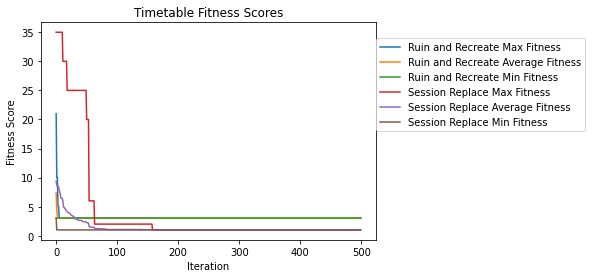

In [26]:
def results():

    #int arrays for fitness results
    RuinNRecreate = np.empty([500, 30], dtype = int)
    SessionReplace = np.empty([500, 30], dtype = int)

    #array for timetable
    timetableRR = np.empty([20, 3], dtype=object)
    timetableSS = np.empty([20, 3], dtype=object)


    sessionReplaceList = []
    RuinNRecreateList = []
    
    #run each hillclimber for 30 times
    for nth in range(30):

        # Run hillclimber here
        solution, fitness, timetable = hillclimber(500, generate_timetable, ruin_recreate, less_than_equal, nth, RuinNRecreate)
        solution2, fitness2, timetable2 = hillclimber(500, generate_timetable, session_replace, less_than_equal, nth, SessionReplace)
        sessionReplaceList.append(fitness2)
        RuinNRecreateList.append(fitness)
        timetableRR = (timetable)
        timetableSS =(timetable2)

    print(f"Ruin and Recreate: {RuinNRecreateList}")
    print(f"Session Replace: {sessionReplaceList}")
    print(f"Example timetable using Ruin and Recreate: \n{timetableRR}")
    print(f"Example timetable using Session Replace: \n{timetableSS}")
    
    plot_graph(RuinNRecreate, SessionReplace)
    
results()

#### Conclusion

The results show that the Session Replace operator is significantly better for optimising a timetable. As you can see, the maximum fitness of the Session Replace operator has levelled out better than the best fitness of the Ruin and Recreate operator after about 225 iterations. And also the Session Replace fitnesses seems to decrease exponentially over time, this is due to replacing the sessions that are causing the constraints to tally up which correlates to the fitness of the operator. Whereas the Ruin and Recreate operator destroys the existing solution and generates a new solution.
